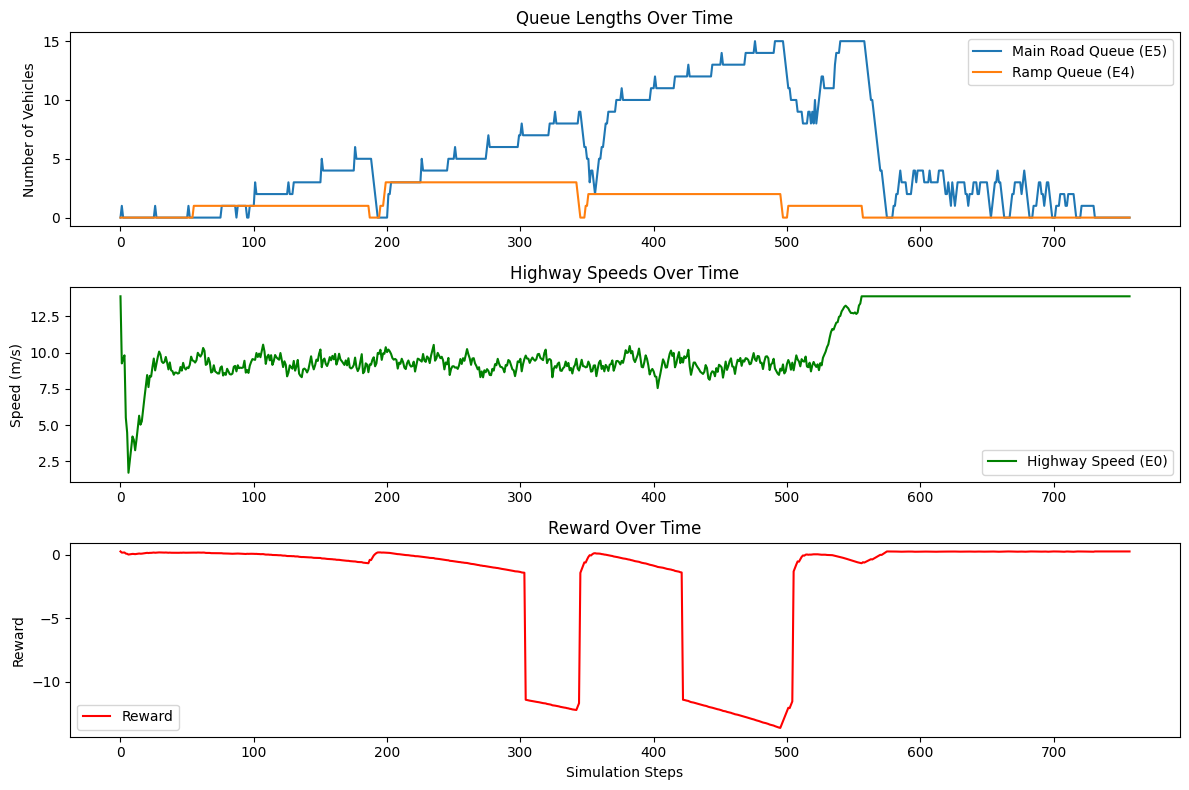

Total Reward from Test: -1591.1192927401205
Number of Steps: 758


In [1]:
import traci
import numpy as np
import matplotlib.pyplot as plt
import pickle

# --- Constants ---
STATE_DIM = 5
ACTION_DIM = 2
MAX_STEPS = 2000  # Maximum steps for testing

# Load the trained Q-table
with open(r"..\models\q_table.pkl", "rb") as f:
    q_table = pickle.load(f)

# --- Helper Functions ---
def get_state():
    """Fetch the current state from the simulator."""
    state = [
        traci.edge.getLastStepHaltingNumber("E5"),  # Number of halting vehicles in E5
        traci.edge.getLastStepHaltingNumber("E4"),  # Number of halting vehicles in E4
        traci.edge.getLastStepMeanSpeed("E0"),      # Average speed on E0 (highway)
        traci.edge.getWaitingTime("E4"),            # Waiting time in E4
        traci.edge.getWaitingTime("E5"),            # Waiting time in E5
    ]
    return np.array(state)

def discretize_state(state):
    """Discretize the continuous state values to fit the Q-table."""
    state_idx = []
    for i, val in enumerate(state):
        state_idx.append(min(int(val // 10), 9))  # 10 bins per state
    return tuple(state_idx)

def calculate_reward(state):
    """Calculate the reward based on traffic metrics."""
    ramp_waiting_time = state[3] + state[4]  # Total ramp waiting time (E4 + E5)
    highway_flow = state[2]  # Highway flow is the average speed on E0
    max_ramp_waiting = 1000
    max_highway_speed = 50

    # Normalize metrics
    normalized_rwt = ramp_waiting_time / max_ramp_waiting
    normalized_hf = highway_flow / max_highway_speed

    # Weights
    alpha = 2.0  # Weight for ramp waiting time
    beta = 1.0   # Weight for highway flow

    # Reward calculation
    reward = -alpha * normalized_rwt + beta * normalized_hf
    
    # Penalty for extreme congestion
    if ramp_waiting_time > max_ramp_waiting * 0.8:
        reward -= 10  # Strong penalty for high congestion

    return reward

def check_if_done():
    """Define termination condition."""
    return traci.simulation.getTime() > MAX_STEPS

# --- Testing Loop ---
traci.start(["sumo", "-c", r"..\sumo_config\simulation.sumocfg"])  # Update the path

state = get_state()
total_reward = 0
step = 0

# Logging metrics for analysis
queue_lengths = []
average_speeds = []
rewards = []

try:
    while traci.simulation.getMinExpectedNumber() > 0:
        # Predict the best action using the Q-table
        state_idx = discretize_state(state)
        action = np.argmax(q_table[state_idx])

        # Apply the chosen action
        traci.trafficlight.setPhase("J7", action)
        traci.simulationStep()
        step += 1

        # Get the next state and calculate reward
        next_state = get_state()
        reward = calculate_reward(state)

        # Logging metrics
        queue_lengths.append((state[0], state[1]))  # Halting vehicles
        average_speeds.append(state[2])  # Highway speed
        rewards.append(reward)

        # Update state and accumulate reward
        state = next_state
        total_reward += reward

        if check_if_done():
            break

finally:
    # Close the SUMO simulation
    traci.close()

# --- Visualization ---
# Queue lengths
main_road_queues, ramp_queues = zip(*queue_lengths)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(main_road_queues, label="Main Road Queue (E5)")
plt.plot(ramp_queues, label="Ramp Queue (E4)")
plt.ylabel("Number of Vehicles")
plt.title("Queue Lengths Over Time")
plt.legend()

# Average speeds
plt.subplot(3, 1, 2)
plt.plot(average_speeds, label="Highway Speed (E0)", color="green")
plt.ylabel("Speed (m/s)")
plt.title("Highway Speeds Over Time")
plt.legend()

# Rewards
plt.subplot(3, 1, 3)
plt.plot(rewards, label="Reward", color="red")
plt.xlabel("Simulation Steps")
plt.ylabel("Reward")
plt.title("Reward Over Time")
plt.legend()

plt.tight_layout()
plt.show()

# Print total reward
print(f"Total Reward from Test: {total_reward}")
print(f"Number of Steps: {step}")
